In [49]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets.mnist import MNIST
from torch.utils.data.dataset import Subset

from pytoune.framework import Model, ModelCheckpoint, CSVLogger
from pytoune import torch_to_numpy
from pytoune.layers import Flatten

import matplotlib.pyplot as plt
%matplotlib inline

On se déclare ici un réseau de neurones très simple:
- Simple séparateur linéaire
- 10 neurones
- 784 poids par neurones

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fully_connected = nn.Linear(28 * 28, 10)

    def forward(self, image):
        # Image shape is (1, 28, 28)
        # View turns it into (1, 784)
        image = image.view(-1, 28 * 28)
        output = self.fully_connected(image)
        return output

In [38]:
net = Net()
net

Net(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [39]:
w, b = net.parameters()

In [40]:
w, w.shape

(Parameter containing:
 tensor([[-0.0109,  0.0271,  0.0339,  ..., -0.0201, -0.0120,  0.0302],
         [ 0.0037,  0.0299, -0.0195,  ...,  0.0096,  0.0201, -0.0311],
         [-0.0100,  0.0177, -0.0264,  ...,  0.0326, -0.0025,  0.0238],
         ...,
         [ 0.0333, -0.0176, -0.0191,  ..., -0.0095,  0.0280, -0.0354],
         [-0.0252, -0.0156,  0.0130,  ..., -0.0174,  0.0173, -0.0241],
         [ 0.0145,  0.0032,  0.0354,  ..., -0.0149, -0.0073,  0.0317]],
        requires_grad=True), torch.Size([10, 784]))

In [41]:
b, b.shape

(Parameter containing:
 tensor([-0.0270,  0.0183,  0.0291,  0.0096, -0.0270,  0.0218, -0.0220, -0.0298,
          0.0273,  0.0265], requires_grad=True), torch.Size([10]))

In [42]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")
train_split_percent = 0.8
batch_size = 32
learning_rate = 0.01
n_epoch = 5
num_classes = 10

In [43]:
train_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./mnist/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(train_dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

split = math.floor(train_split_percent * num_data)

train_indices = indices[:split]
train_dataset = Subset(train_dataset, train_indices)

valid_indices = indices[split:]
valid_dataset = Subset(valid_dataset, valid_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [44]:
def train(name, pytorch_module):
    # One nice feature of Pytoune is callbacks.
    callbacks = []
    
    optimizer = optim.SGD(pytorch_module.parameters(), lr=learning_rate, weight_decay=0.001)
    loss_function = nn.CrossEntropyLoss()

    # Pytoune Model
    model = Model(pytorch_module, optimizer, loss_function, metrics=['accuracy'])

    # Send model on GPU
    model.to(device)

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [45]:
train('fc', net)

Epoch 1/5 16.06s Step 1500/1500: loss: 0.838002, acc: 81.970833, val_loss: 0.528821, val_acc: 87.783333
Epoch 2/5 16.52s Step 1500/1500: loss: 0.485561, acc: 87.683333, val_loss: 0.438331, val_acc: 89.125000
Epoch 3/5 15.35s Step 1500/1500: loss: 0.426392, acc: 88.756250, val_loss: 0.401422, val_acc: 89.883333
Epoch 4/5 13.35s Step 1500/1500: loss: 0.397059, acc: 89.291667, val_loss: 0.381339, val_acc: 90.275000
Epoch 5/5 15.28s Step 1500/1500: loss: 0.378874, acc: 89.725000, val_loss: 0.367139, val_acc: 90.558333
Test:
	Loss: 0.35133745963573454
	Accuracy: 90.65


In [47]:
w, b = net.parameters()

In [48]:
w

Parameter containing:
tensor([[-0.0101,  0.0251,  0.0314,  ..., -0.0187, -0.0111,  0.0280],
        [ 0.0034,  0.0277, -0.0181,  ...,  0.0089,  0.0187, -0.0289],
        [-0.0092,  0.0164, -0.0245,  ...,  0.0302, -0.0023,  0.0221],
        ...,
        [ 0.0309, -0.0164, -0.0177,  ..., -0.0088,  0.0260, -0.0329],
        [-0.0234, -0.0144,  0.0120,  ..., -0.0162,  0.0161, -0.0223],
        [ 0.0135,  0.0030,  0.0329,  ..., -0.0138, -0.0068,  0.0294]],
       requires_grad=True)

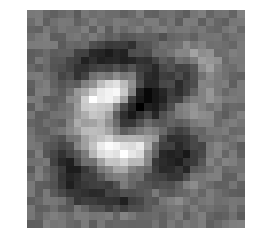

In [56]:
plt.imshow(w[3].view(28, 28).data, cmap='gray_r')
plt.axis('off')
plt.show()